<a href="https://www.kaggle.com/code/shaikhabdulrafay03/taylor-swift-data?scriptVersionId=158902513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import nltk
import spacy
import re
import string
from spacy.lang.en import English

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [10]:
df = pd.read_csv(r"C:\Users\minal\Downloads\taylor_swift_videos.csv")

df

,title,published_at,duration,view_count
0,Taylor Swift - You're Losing Me (From The Vault),2023-11-29T13:00:47Z,PT4M39S,7278886
1,"Rent on demand starting … you guessed it, Dece...",2023-11-27T20:21:45Z,PT1M1S,1050064
2,✨🫶 My name is Taylor and I was born in 1989 🫶✨,2023-10-31T20:08:57Z,PT19S,1196267
3,Taylor Swift - Cruel Summer (LP Giobbi Remix),2023-10-19T00:30:06Z,PT3M19S,696792
4,Taylor Swift - Cruel Summer (Live from Taylor ...,2023-10-19T00:30:25Z,PT3M55S,3437493
...,...,...,...,...
218,First fans with my CMT Award.,2008-06-26T21:55:43Z,PT11S,337626
219,TRL Recap!,2008-06-26T21:15:51Z,PT3M8S,742898
220,Wannabe,2008-06-26T21:02:39Z,PT3M45S,1217405
221,:-),2008-06-26T20:51:09Z,PT34S,805812


In [11]:
print("DataFrame Information:")
print("-" * 30)
print('DF Shape: ' ,df.shape)
print('number of Columns: ' ,len(df.columns))
print('number of Observations: ' ,len(df))
print('Number of values in df: ' , df.count().sum())
print('Total Number of Missing values in df: ' , df.isna().sum().sum())
print('percentage of Missing values : ' ,  "{:.2f}".format(df.isna().sum().sum()/df.count().sum() *100),'%')
print('Total Number of Duplicated records in df : ' , df.duplicated().sum().sum())
print('percentage of Duplicated values : ' ,  "{:.2f}".format(df.duplicated().sum().sum()/df.count().sum() *100),'%')

DataFrame Information:
------------------------------
DF Shape:  (223, 4)
number of Columns:  4
number of Observations:  223
Number of values in df:  892
Total Number of Missing values in df:  0
percentage of Missing values :  0.00 %
Total Number of Duplicated records in df :  0
percentage of Duplicated values :  0.00 %


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         223 non-null    object
 1   published_at  223 non-null    object
 2   duration      223 non-null    object
 3   view_count    223 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 7.1+ KB


In [13]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['date'] = df['published_at'].dt.date
df['time'] = df['published_at'].dt.time

In [14]:
def clean_text(x):
    text = re.sub('(\d+)','',x)   
    text = text.lower()
    
    x = text 
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
from datetime import time
def fromat_duration(value):
    s = value.strip('PT')
    s = s.split('M')
    if len(s) > 1:
        if s[1] != '':
            sec = s[1].strip('S')
        else:
            sec = 0
        min = s[0]
    else:
        min = '0'
        sec = s[0].strip('S')
        
    return time(minute= int(min) , second=int(sec))
         

def time_in_seconds(value):
    return (value.minute * 60) + value.second

df['duration'] = df['duration'].apply(fromat_duration)
df['time_in_sec'] = df['duration'].apply(time_in_seconds)


    

In [16]:
df

,title,published_at,duration,view_count,date,time,time_in_sec
0,Taylor Swift - You're Losing Me (From The Vault),2023-11-29 13:00:47+00:00,00:04:39,7278886,2023-11-29,13:00:47,279
1,"Rent on demand starting … you guessed it, Dece...",2023-11-27 20:21:45+00:00,00:01:01,1050064,2023-11-27,20:21:45,61
2,✨🫶 My name is Taylor and I was born in 1989 🫶✨,2023-10-31 20:08:57+00:00,00:00:19,1196267,2023-10-31,20:08:57,19
3,Taylor Swift - Cruel Summer (LP Giobbi Remix),2023-10-19 00:30:06+00:00,00:03:19,696792,2023-10-19,00:30:06,199
4,Taylor Swift - Cruel Summer (Live from Taylor ...,2023-10-19 00:30:25+00:00,00:03:55,3437493,2023-10-19,00:30:25,235
...,...,...,...,...,...,...,...
218,First fans with my CMT Award.,2008-06-26 21:55:43+00:00,00:00:11,337626,2008-06-26,21:55:43,11
219,TRL Recap!,2008-06-26 21:15:51+00:00,00:03:08,742898,2008-06-26,21:15:51,188
220,Wannabe,2008-06-26 21:02:39+00:00,00:03:45,1217405,2008-06-26,21:02:39,225
221,:-),2008-06-26 20:51:09+00:00,00:00:34,805812,2008-06-26,20:51:09,34


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   title         223 non-null    object             
 1   published_at  223 non-null    datetime64[ns, UTC]
 2   duration      223 non-null    object             
 3   view_count    223 non-null    int64              
 4   date          223 non-null    object             
 5   time          223 non-null    object             
 6   time_in_sec   223 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 12.3+ KB


In [18]:
df[df['time_in_sec'] < 60]

,title,published_at,duration,view_count,date,time,time_in_sec
2,✨🫶 My name is Taylor and I was born in 1989 🫶✨,2023-10-31 20:08:57+00:00,00:00:19,1196267,2023-10-31,20:08:57,19
5,The Eras Tour concert film is now officially c...,2023-09-26 11:58:51+00:00,00:00:31,1338900,2023-09-26,11:58:51,31
6,Thank you for making these reveals so much cha...,2023-09-20 22:13:54+00:00,00:00:29,857197,2023-09-20,22:13:54,29
8,Pre order 1989 (Taylor’s Version) now on my si...,2023-08-10 06:26:11+00:00,00:00:16,1489197,2023-08-10,06:26:11,16
9,Summer forecast: Cruel. 😎,2023-07-21 18:56:15+00:00,00:00:26,2505814,2023-07-21,18:56:15,26
...,...,...,...,...,...,...,...
194,New conference table.,2010-03-12 16:10:46+00:00,00:00:31,1318531,2010-03-12,16:10:46,31
207,Retainers.,2008-11-17 21:25:40+00:00,00:00:59,3195952,2008-11-17,21:25:40,59
217,My band has bad private plane manners.,2008-06-26 21:58:19+00:00,00:00:25,837052,2008-06-26,21:58:19,25
218,First fans with my CMT Award.,2008-06-26 21:55:43+00:00,00:00:11,337626,2008-06-26,21:55:43,11


In [19]:
df[df['view_count'] > 10000000]

,title,published_at,duration,view_count,date,time,time_in_sec
7,TAYLOR SWIFT | THE ERAS TOUR Concert Film Offi...,2023-08-31 12:17:49+00:00,00:01:30,11545908,2023-08-31,12:17:49,90
11,Taylor Swift - Snow On The Beach (Feat. More L...,2023-05-26 04:00:01+00:00,00:03:50,11267965,2023-05-26,04:00:01,230
23,"It’s me, Benjamin 🐱 joining the #TSAntiHeroCha...",2022-11-11 17:04:21+00:00,00:00:16,50506505,2022-11-11,17:04:21,16
29,"It’s me, 👋 sharing ALL the problems. Join the ...",2022-11-04 14:53:16+00:00,00:00:16,57972784,2022-11-04,14:53:16,16
31,Total surprise 😉 Share yours with #TSAntiHero...,2022-11-01 12:31:39+00:00,00:00:16,78028885,2022-11-01,12:31:39,16
33,🫣 Join my #TSAntiHeroChallenge and share your ...,2022-10-21 12:10:21+00:00,00:00:16,125922041,2022-10-21,12:10:21,16
34,😺 Join my #TSAntiHeroChallenge and share your ...,2022-10-21 12:10:06+00:00,00:00:16,105500781,2022-10-21,12:10:06,16
51,Taylor Swift - Lover Remix Feat. Shawn Mendes ...,2019-11-13 12:27:46+00:00,00:03:42,39230523,2019-11-13,12:27:46,222
57,Taylor Swift - Lover's Lounge (Live),2019-08-22 21:47:44+00:00,00:33:43,15966196,2019-08-22,21:47:44,2023
58,Taylor Swift - Livestream Announcement (8/22/1...,2019-08-15 18:06:59+00:00,00:00:40,13821516,2019-08-15,18:06:59,40


In [20]:
df['title'] = df['title'].apply(str.lower)

In [21]:
#all taylor swift songs
import requests as req
soups = []
for i in range(1 , 5):
    r = req.get(f"https://www.oldies.com/artist-songs/Taylor-Swift/page_{i}.html")
    print(r.status_code)
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(r.text , "lxml")
    soups.append(soup)

200
200
200
200


In [22]:
name =[]
for soup in soups:
    names = soup.find_all('span' , {'class' : 'PLT'})   
    print(len(names))
    for i in names:
        name.append(i.string) 

521
350
0
0


In [23]:
songnames = [song.lower() for song in name]

In [24]:
def tour (title  , duration):
    x = ''
    if pd.Series(title).str.contains('tour').bool():
       x =  x +' tour'
        
    if pd.Series(title).str.contains('behind the scenes').bool():
        x = x + ' BTS'             

    if pd.Series(title).str.contains('short').bool():
        x = x + ' short'
    elif duration < 60:
        x = x + ' short'
    if pd.Series(title).str.contains('remix').bool():
        x = x + ' remix'            

    if pd.Series(title).str.contains('trailer').bool():
        x = x + ' trailer'            
    
    if pd.Series(title).str.contains('featuring').bool():
        x = x + ' featuring'            

    if  any(keyword.lower() in title for keyword in songnames ):
        x = x+' music'
    if  x == '':
        return None      
    return x
df['Tags'] = df['Tags'] = df.apply(lambda row: tour(row['title'], row['time_in_sec']), axis=1)



In [25]:
tags = df['Tags'].str.get_dummies(sep=' ')

In [26]:
tags

,BTS,featuring,music,remix,short,tour,trailer
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,1,1,0,0,0
4,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...
218,0,0,0,0,1,0,0
219,0,0,0,0,0,0,0
220,0,0,0,0,0,0,0
221,0,0,0,0,1,0,0


In [27]:
tags['music'].value_counts()

music
1    126
0     97
Name: count, dtype: int64

In [34]:
newdf = pd.concat([df, tags], axis=1)
newdf.to_csv('Taylor.csv', index=False)
newdf

,title,published_at,duration,view_count,date,time,time_in_sec,Tags,BTS,featuring,music,remix,short,tour,trailer
0,taylor swift - you're losing me (from the vault),2023-11-29 13:00:47+00:00,00:04:39,7278886,2023-11-29,13:00:47,279,None,0,0,0,0,0,0,0
1,"rent on demand starting … you guessed it, dece...",2023-11-27 20:21:45+00:00,00:01:01,1050064,2023-11-27,20:21:45,61,None,0,0,0,0,0,0,0
2,✨🫶 my name is taylor and i was born in 1989 🫶✨,2023-10-31 20:08:57+00:00,00:00:19,1196267,2023-10-31,20:08:57,19,short,0,0,0,0,1,0,0
3,taylor swift - cruel summer (lp giobbi remix),2023-10-19 00:30:06+00:00,00:03:19,696792,2023-10-19,00:30:06,199,remix music,0,0,1,1,0,0,0
4,taylor swift - cruel summer (live from taylor ...,2023-10-19 00:30:25+00:00,00:03:55,3437493,2023-10-19,00:30:25,235,tour music,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,first fans with my cmt award.,2008-06-26 21:55:43+00:00,00:00:11,337626,2008-06-26,21:55:43,11,short,0,0,0,0,1,0,0
219,trl recap!,2008-06-26 21:15:51+00:00,00:03:08,742898,2008-06-26,21:15:51,188,None,0,0,0,0,0,0,0
220,wannabe,2008-06-26 21:02:39+00:00,00:03:45,1217405,2008-06-26,21:02:39,225,None,0,0,0,0,0,0,0
221,:-),2008-06-26 20:51:09+00:00,00:00:34,805812,2008-06-26,20:51:09,34,short,0,0,0,0,1,0,0


In [35]:
line = px.line(newdf, x='time', y='view_count', title='Line Chart')
line.show()


In [37]:
line = px.line(newdf, x='time_in_sec', y='view_count', title='Line Chart')
line.show()


In [38]:
line_chart = px.line(df, x='date', y='view_count', title='Line Chart')
line_chart.show()

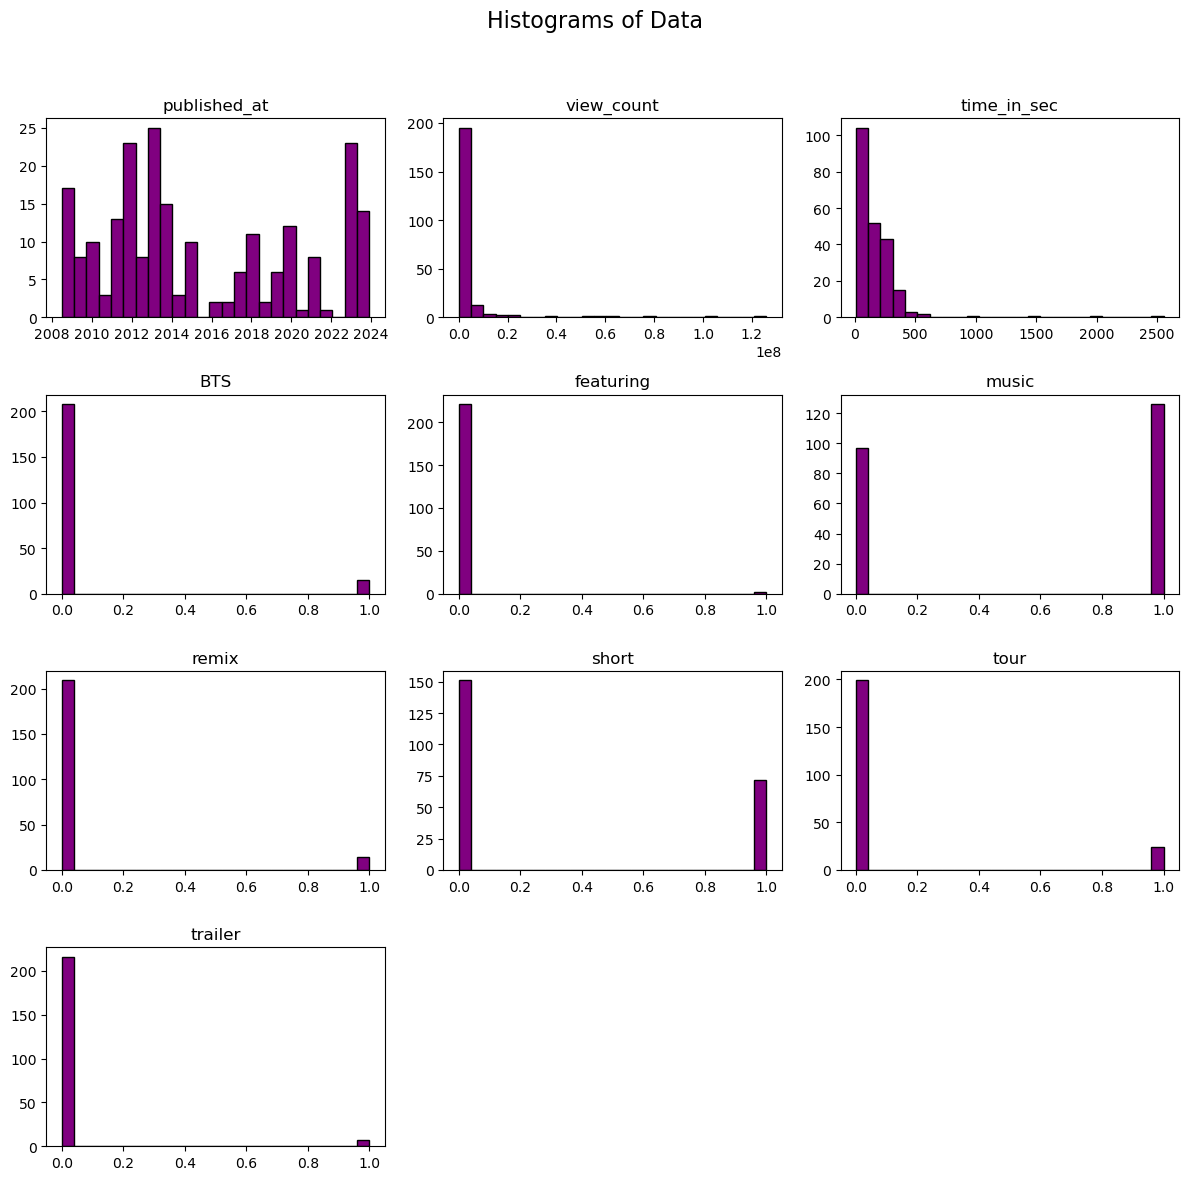

In [41]:
newdf.hist(bins = 25, color='purple', edgecolor='black', grid=False , figsize = (12, 12) )
# Add titles and labels
plt.suptitle('Histograms of Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing between subplots
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Modify tick font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove outer spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.show()